In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
import scipy.stats as ss

In [2]:
pd.options.display.max_columns = 50

In [3]:
summary = pd.read_csv('data/summary.csv')
day1 = pd.read_csv('data/day 1.csv')

In [4]:
day1.head(20)

,Unnamed: 0,assessment,day,event,patient,time
0,0,NaN,1,arrived,1,280
1,1,NaN,1,arrived,2,288
2,2,NaN,1,assessment initiated,1,308
3,3,NaN,1,arrived,3,430
4,4,urgent|36.599999999999994|no pain,1,assessment concluded,1,741
5,5,NaN,1,assessment initiated,2,764
6,6,NaN,1,consultation_initiated,1,773
7,7,normal|36.699999999999996|severe pain,1,assessment concluded,2,851
8,8,NaN,1,assessment initiated,3,878
9,9,NaN,1,consultation_initiated,2,905


In [5]:
summary.corr()['duration']

Unnamed: 0                -0.043085
arrival_time              -0.034497
assessment_end_time       -0.066131
assessment_start_time     -0.065776
consultation_end_time      0.038430
consultation_start_time   -0.066377
day                       -0.044200
duration                   1.000000
patient                   -0.044809
temperature                0.298949
Name: duration, dtype: float64

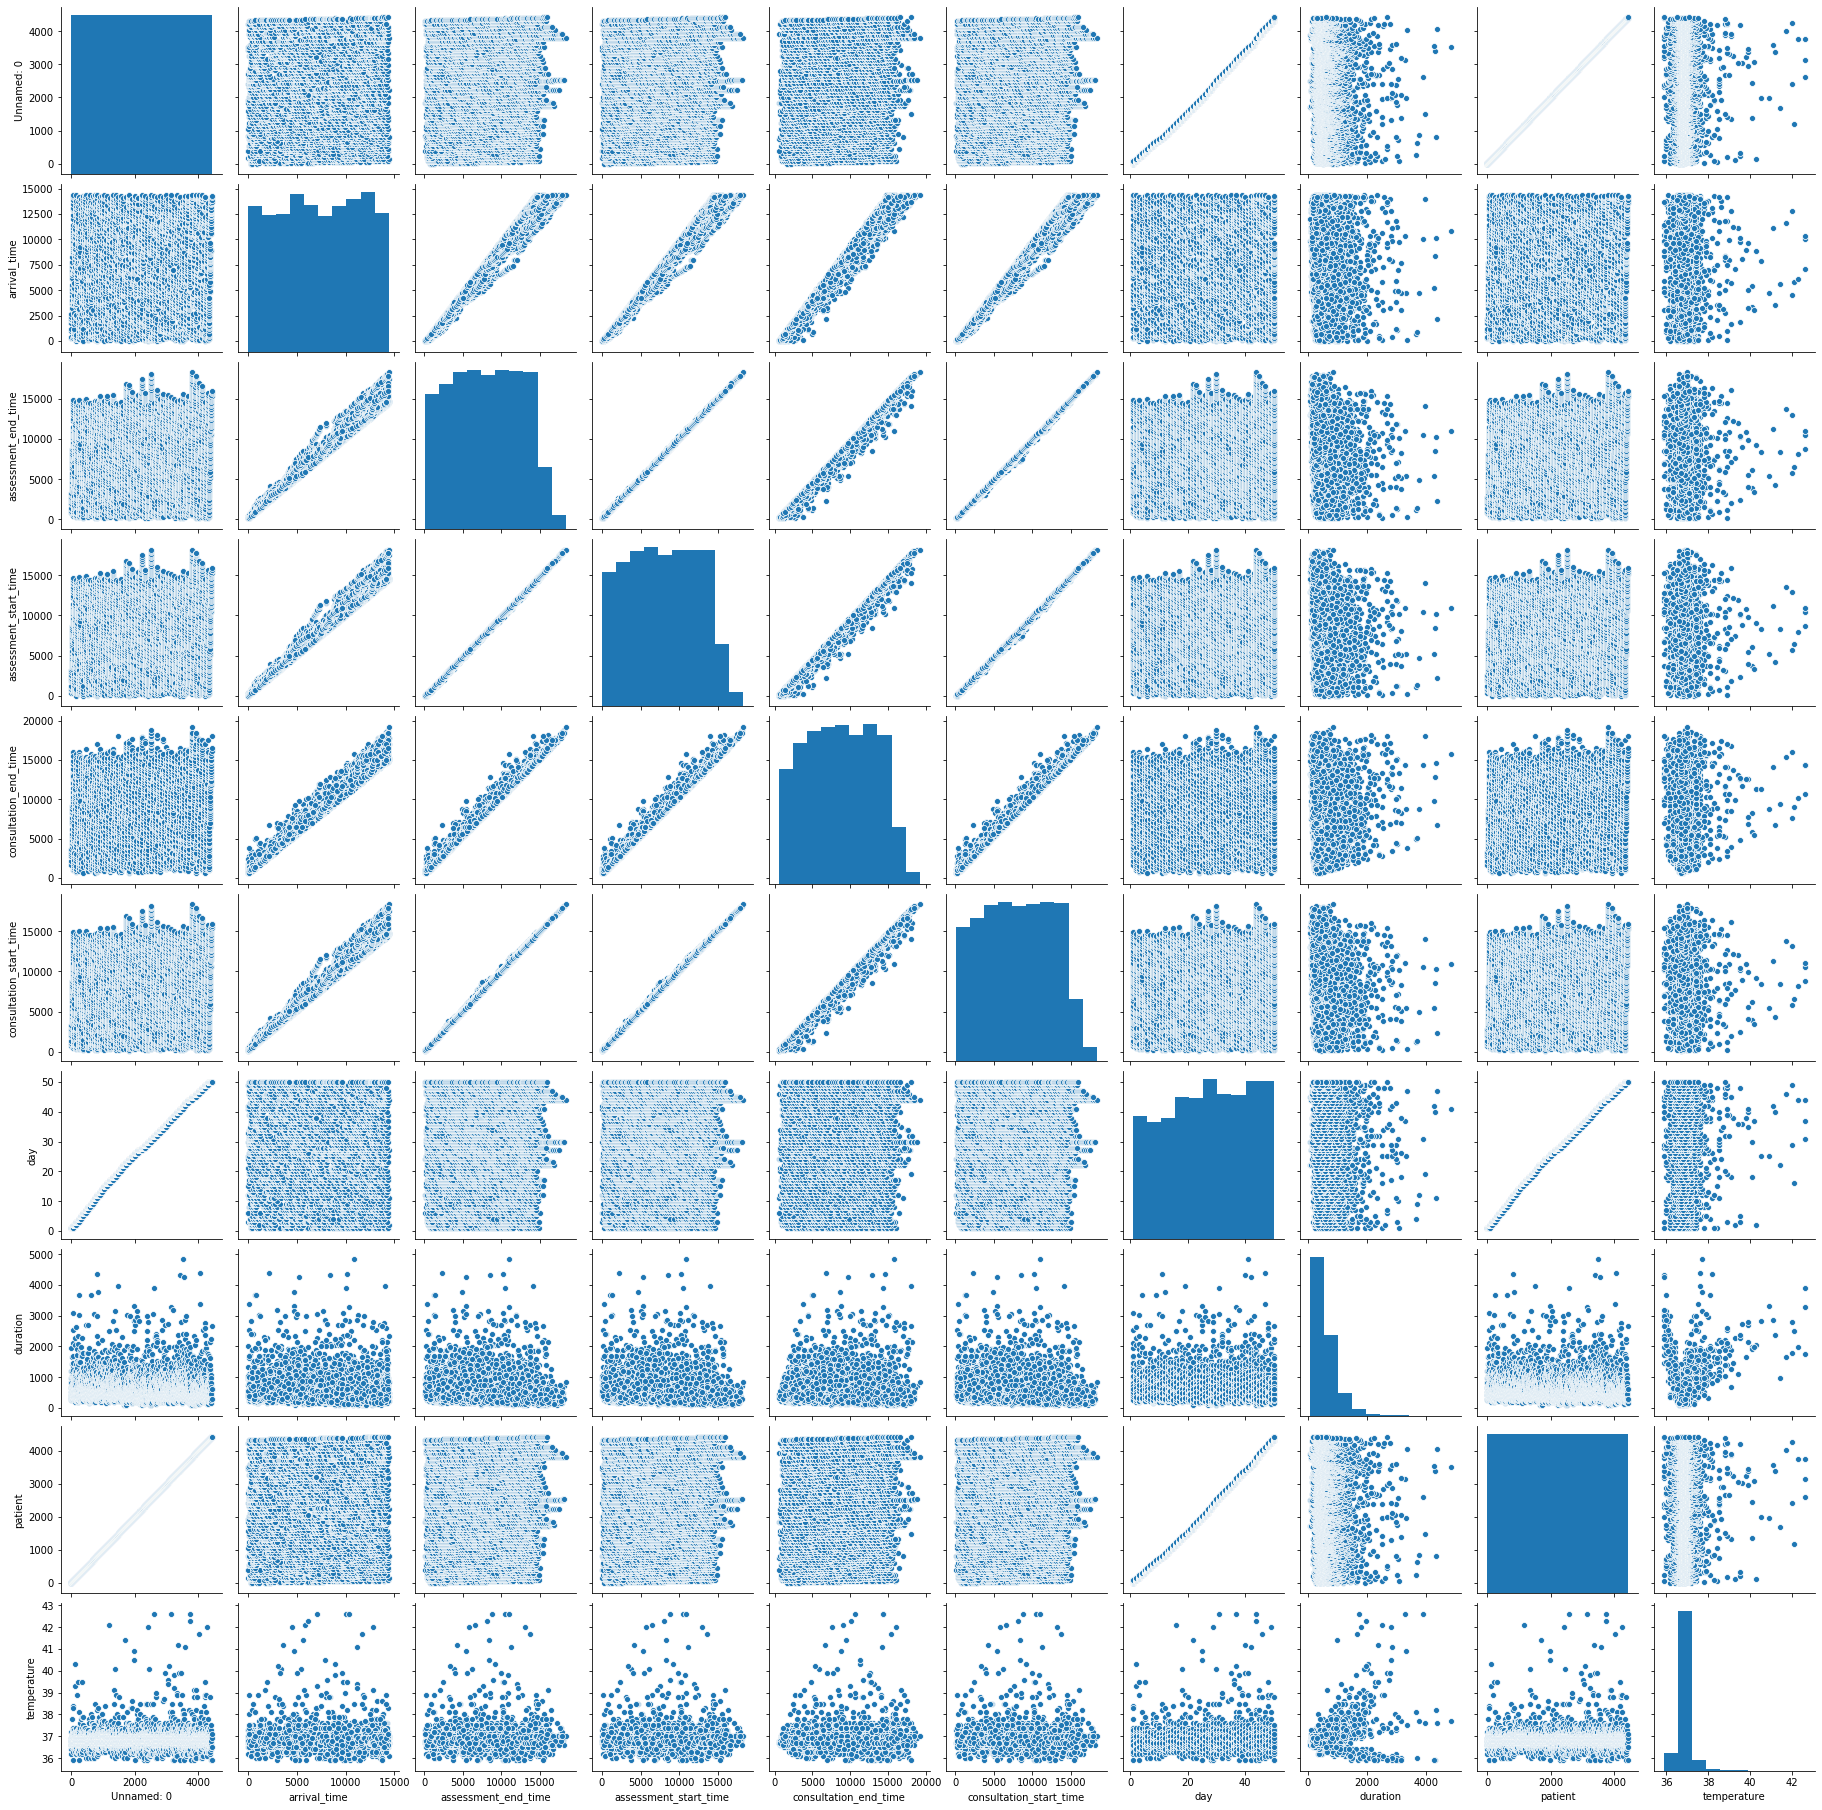

In [6]:
sns.pairplot(summary);

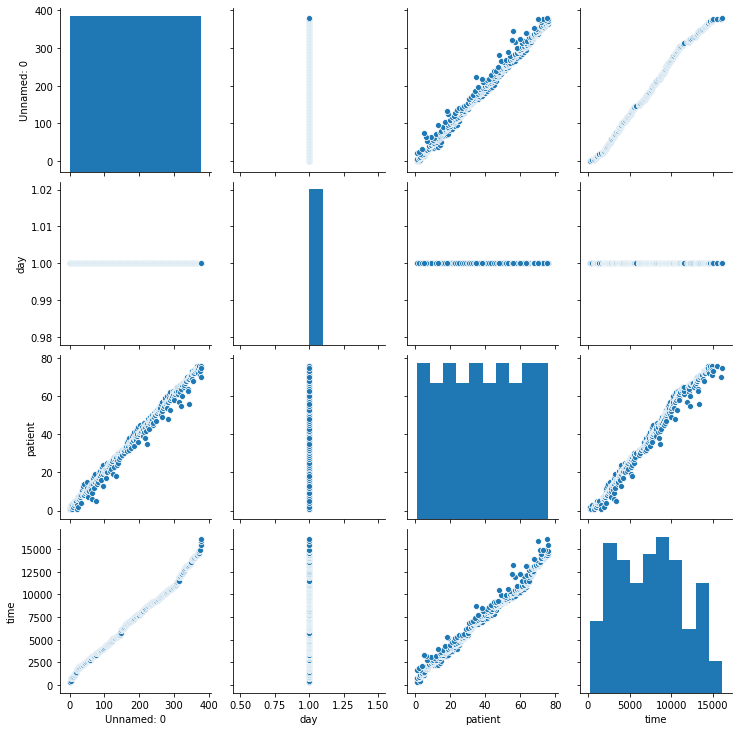

In [7]:
sns.pairplot(day1);

In [8]:
print(summary.shape)
print(len(summary['Unnamed: 0'].unique()))
print(len(summary['patient'].unique()))

(4420, 12)
4420
4420


In [9]:
summary.head(20)

,Unnamed: 0,arrival_time,assessment_end_time,assessment_start_time,consultation_end_time,consultation_start_time,day,duration,pain,patient,priority,temperature
0,1,280,741,308,1620,773,1,847,no pain,1,urgent,36.6
1,2,288,851,764,1881,905,1,976,severe pain,2,normal,36.7
2,0,430,1055,878,1595,1084,1,510,severe pain,3,normal,36.8
3,3,944,1244,1089,2105,1294,1,810,severe pain,4,urgent,36.6
4,11,1139,1351,1267,3322,1378,1,1943,severe pain,5,urgent,36.2
5,9,1773,1923,1811,3141,1946,1,1195,moderate pain,6,normal,36.4
6,5,1798,2042,1948,2763,2065,1,697,no pain,7,urgent,37.2
7,4,2099,2248,2139,2717,2289,1,427,no pain,8,normal,36.7
8,8,2173,2405,2280,3083,2434,1,648,moderate pain,9,normal,36.6
9,6,2199,2502,2435,2791,2524,1,266,moderate pain,10,normal,36.8


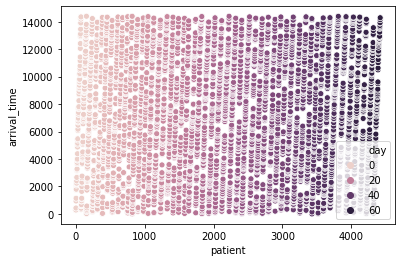

In [10]:
sns.scatterplot('patient', 'arrival_time', data=summary, hue='day');

In [11]:
summary.loc[summary['day'] == 50, 'arrival_time'].corr(summary.loc[summary['day'] == 50, 'patient'])

0.9953782079689507

In [12]:
df = summary.sort_values(['day', 'arrival_time'])

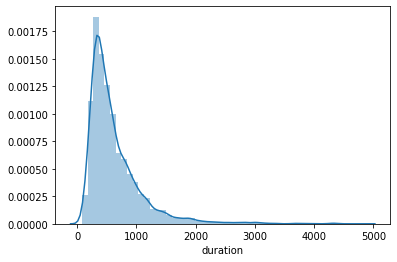

In [13]:
sns.distplot(df['duration']);

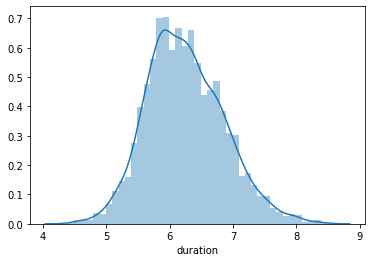

In [14]:
sns.distplot(np.log(df['duration']));

In [15]:
df['log_consult_duration'] = np.log(df['duration'])

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4420 entries, 0 to 4419
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               4420 non-null   int64  
 1   arrival_time             4420 non-null   int64  
 2   assessment_end_time      4420 non-null   int64  
 3   assessment_start_time    4420 non-null   int64  
 4   consultation_end_time    4420 non-null   int64  
 5   consultation_start_time  4420 non-null   int64  
 6   day                      4420 non-null   int64  
 7   duration                 4420 non-null   int64  
 8   pain                     4420 non-null   object 
 9   patient                  4420 non-null   int64  
 10  priority                 4420 non-null   object 
 11  temperature              4420 non-null   float64
 12  log_consult_duration     4420 non-null   float64
dtypes: float64(2), int64(9), object(2)
memory usage: 483.4+ KB


In [17]:
df = pd.get_dummies(df)

In [22]:
df['assessment_duration'] = df['assessment_end_time'] - df['assessment_start_time']

In [23]:
cols_to_drop = ['Unnamed: 0', 'assessment_end_time',
                'consultation_end_time', 'duration', 'patient']
df.drop(cols_to_drop, axis=1, inplace=True)

In [24]:
df['pain_no pain:priority_normal'] = df['pain_no pain'] * df['priority_normal']
df['pain_moderate pain:priority_normal'] = df['pain_moderate pain'] * df['priority_normal']
df['pain_severe pain:priority_normal'] = df['pain_severe pain'] * df['priority_normal']

df['pain_no pain:priority_urgent'] = df['pain_no pain'] * df['priority_urgent']
df['pain_moderate pain:priority_urgent'] = df['pain_moderate pain'] * df['priority_urgent']
df['pain_severe pain:priority_urgent'] = df['pain_severe pain'] * df['priority_urgent']

df.drop(['pain_no pain', 'pain_moderate pain', 'pain_severe pain',
         'priority_normal', 'priority_urgent'], axis=1, inplace=True)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4420 entries, 0 to 4419
Data columns (total 13 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   arrival_time                        4420 non-null   int64  
 1   assessment_start_time               4420 non-null   int64  
 2   consultation_start_time             4420 non-null   int64  
 3   day                                 4420 non-null   int64  
 4   temperature                         4420 non-null   float64
 5   log_consult_duration                4420 non-null   float64
 6   assessment_duration                 4420 non-null   int64  
 7   pain_no pain:priority_normal        4420 non-null   uint8  
 8   pain_moderate pain:priority_normal  4420 non-null   uint8  
 9   pain_severe pain:priority_normal    4420 non-null   uint8  
 10  pain_no pain:priority_urgent        4420 non-null   uint8  
 11  pain_moderate pain:priority_urgent  4420 no

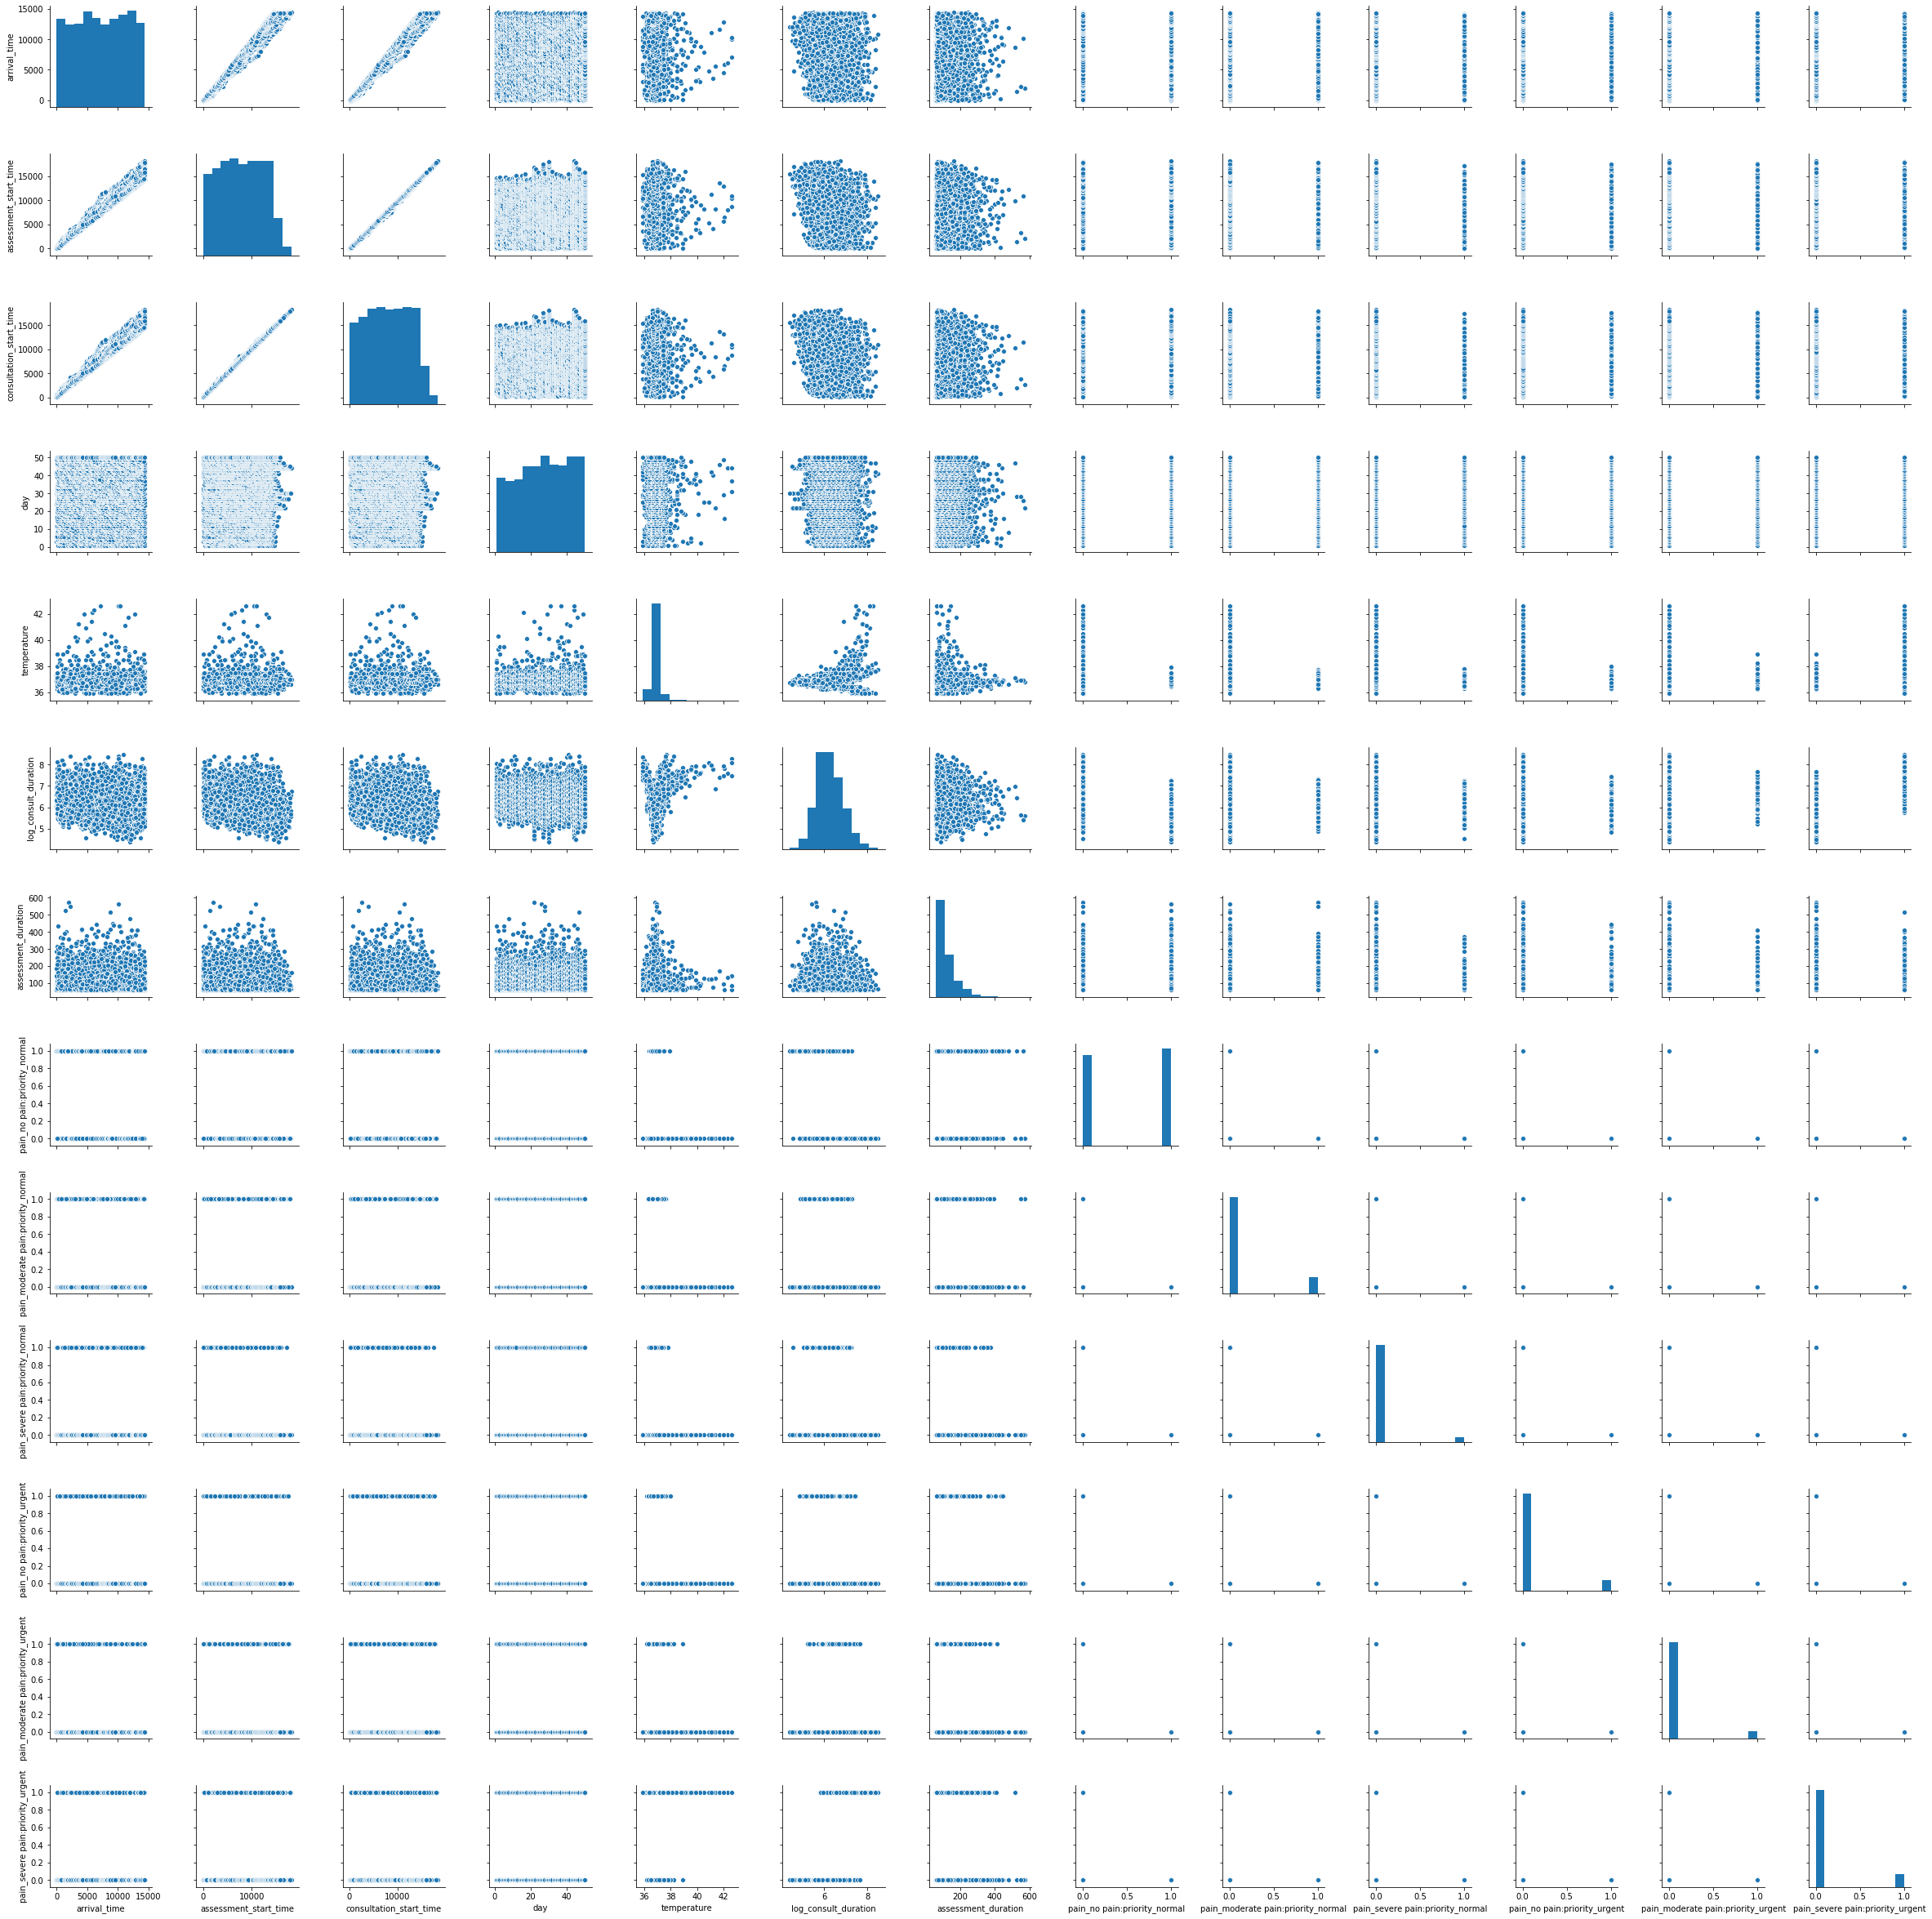

In [31]:
sns.pairplot(df);

In [26]:
df

,arrival_time,assessment_start_time,consultation_start_time,day,temperature,log_consult_duration,assessment_duration,pain_no pain:priority_normal,pain_moderate pain:priority_normal,pain_severe pain:priority_normal,pain_no pain:priority_urgent,pain_moderate pain:priority_urgent,pain_severe pain:priority_urgent
0,280,308,773,1,36.6,6.741701,433,0,0,0,1,0,0
1,288,764,905,1,36.7,6.883463,87,0,0,1,0,0,0
2,430,878,1084,1,36.8,6.234411,177,0,0,1,0,0,0
3,944,1089,1294,1,36.6,6.697034,155,0,0,0,0,0,1
4,1139,1267,1378,1,36.2,7.571988,84,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4415,13730,15304,15398,50,35.9,7.889084,64,0,0,0,0,0,1
4416,13893,15403,15584,50,36.8,5.583496,144,1,0,0,0,0,0
4417,13931,15583,15703,50,36.5,6.398595,97,0,0,1,0,0,0
4418,14147,15698,15856,50,36.9,5.720312,131,1,0,0,0,0,0


In [27]:
X_train = df[df['day'] <= 45].drop(['day', 'log_consult_duration'], axis=1)
X_test = df[df['day'] > 45].drop(['day', 'log_consult_duration'], axis=1)
y_train = df.loc[df['day'] <= 45, 'log_consult_duration']
y_test = df.loc[df['day'] > 45, 'log_consult_duration']

In [28]:
tscv = TimeSeriesSplit(n_splits=5)

elnet = ElasticNet(normalize=True, random_state=42)

elnet_params ={'alpha': ss.uniform(-1, 1),
              'l1_ratio': ss.uniform(0, 1)}

rscv = RandomizedSearchCV(elnet,
                          elnet_params,
                          n_iter=1000,
                          scoring='neg_root_mean_squared_error',
                          n_jobs=-1,
                          cv=tscv,
                          verbose=1,
                          random_state=42,
                          return_train_score=True)

rscv.fit(X_train, y_train)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 832 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 2832 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:   20.4s finished
/home/jeffc/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:788: RuntimeWarning: invalid value encountered in subtract
  array_means[:, np.newaxis]) ** 2,
/home/jeffc/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: nan, tolerance: 0.14371954865209136
  positive)


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
                   error_score=nan,
                   estimator=ElasticNet(alpha=1.0, copy_X=True,
                                        fit_intercept=True, l1_ratio=0.5,
                                        max_iter=1000, normalize=True,
                                        positive=False, precompute=False,
                                        random_state=42, selection='cyclic',
                                        tol=0.0001, warm_start=False),
                   iid='deprecated', n_iter=1000, n_jobs=-1,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fbf4c8cb8d0>,
                                        'l1_ratio': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fbf496329d0>},
                   pre_dispatch='2*n_jobs', random_state=42, refit=True,
                   return_train_score=True,
                   scoring='neg_root_

In [29]:
lm = rscv.best_estimator_
lm

ElasticNet(alpha=-0.013369877041153111, copy_X=True, fit_intercept=True,
           l1_ratio=0.9651186964360455, max_iter=1000, normalize=True,
           positive=False, precompute=False, random_state=42,
           selection='cyclic', tol=0.0001, warm_start=False)

In [30]:
cv_results = pd.DataFrame(rscv.cv_results_)
train_rmse = -cv_results.loc[rscv.best_index_, 'mean_train_score']
val_rmse = -cv_results.loc[rscv.best_index_, 'mean_test_score']

test_rmse = mean_squared_error(y_test, lm.predict(X_test))

print(f'train rmse: {train_rmse}')
print(f'val rmse: {val_rmse}')
print(f'test rmse: {test_rmse}')

train rmse: 0.5670562897662552
val rmse: 0.6150645275057997
test rmse: 0.3720157431368499
